In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.compat.v1 import keras as K
import tensorflow as tf
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Define the root directory containing student subdirectories
root_directory = "C:/Users/HP/OneDrive/Documents/Photos"

# Initialize lists to store data
data = []
labels = []
common_size = (224, 224)  # Adjust the size as needed

# Iterate through each subdirectory (student)
for student_name in os.listdir(root_directory):
    student_directory = os.path.join(root_directory, student_name)
    
    # Check if it's a directory
    if os.path.isdir(student_directory):
        # Iterate through each image file in the student's directory
        for image_file in os.listdir(student_directory):
            image_path = os.path.join(student_directory, image_file)
            
            # Read the image using OpenCV
            img = cv2.imread(image_path)
            img_resized = cv2.resize(img, common_size)
            
            # Append the resized image and label to the data lists
            data.append(img_resized)
            labels.append(student_name)

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Print the shape of the data and labels arrays
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print(np.unique(labels))
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

Data shape: (89, 224, 224, 3)
Labels shape: (89,)
['Abhinav, 060' 'Harshitha, 018' 'K_vishnu, 032'
 'Ramaraju_Sree_Virajitha, 047' 'Vanapalli_Naga_Varnika, 059']


In [3]:
labels_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4], dtype=int64)

In [4]:
# Use data augmentation
datagen_train = ImageDataGenerator(
    rotation_range=20,       
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Split the dataset into training and testing sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# Print the shape of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (71, 224, 224, 3)
X_test shape: (18, 224, 224, 3)
y_train shape: (71,)
y_test shape: (18,)


In [5]:
from tensorflow.keras.applications import MobileNetV2
base_model = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Change 1 to 3 for RGB
# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [6]:

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(np.unique(labels)), activation='softmax'))


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with data augmentation
# Convert string labels to numerical format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
train_generator = datagen_train.flow(X_train, y_train_encoded, batch_size=32)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 10287429 (39.24 MB)
Trainable params: 8029

In [8]:
history = model.fit(train_generator, epochs=50, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Evaluate the model on the test set using data generator
test_generator = datagen_train.flow(X_test, y_test_encoded, batch_size=32)
accuracy = model.evaluate(test_generator)[1]
print("Test Accuracy: {:.2f}%".format(accuracy * 100))


Epoch 1/50


3/3 [==============================] - 9s 2s/step - loss: 1.7951 - accuracy: 0.3803 - val_loss: 5.2600 - val_accuracy: 0.7222
Epoch 2/50
3/3 [==============================] - 2s 929ms/step - loss: 0.3122 - accuracy: 0.9014 - val_loss: 3.4092 - val_accuracy: 0.7222
Epoch 3/50
3/3 [==============================] - 2s 623ms/step - loss: 0.2171 - accuracy: 0.9155 - val_loss: 2.3822 - val_accuracy: 0.7222
Epoch 4/50
3/3 [==============================] - 2s 582ms/step - loss: 0.3594 - accuracy: 0.8873 - val_loss: 1.2769 - val_accuracy: 0.7222
Epoch 5/50
3/3 [==============================] - 2s 929ms/step - loss: 0.2213 - accuracy: 0.9577 - val_loss: 0.7770 - val_accuracy: 0.7778
Epoch 6/50
3/3 [==============================] - 2s 614ms/step - loss: 0.1215 - accuracy: 0.9577 - val_loss: 0.4649 - val_accuracy: 0.8889
Epoch 7/50
3/3 [==============================] - 2s 928ms/step - loss: 0.1889 - accuracy: 0.9437 - val_loss: 0.3313 - val_accuracy: 0.9444
Epoch 8/50
3/3 [=====

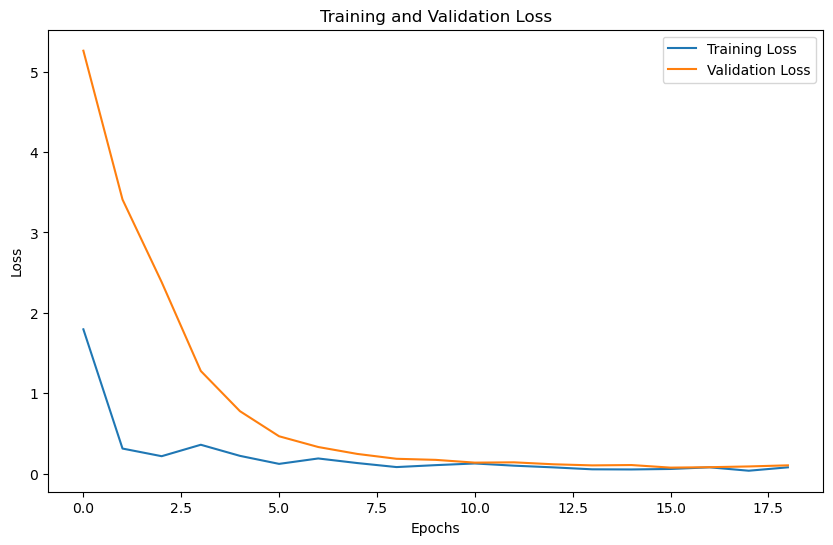

In [9]:
# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Create a face cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [11]:
# Initialize attendance_df outside the function
attendance_df = pd.DataFrame(columns=['Name', 'Time', 'Date'])

# Initialize a buffer for smoothing predicted labels
label_buffer = []

# Initialize temp as a global variable
global temp
temp = 0

def mark_attendance(predictions):
    global attendance_df, temp
    
    # Check if the label buffer is empty
    if not label_buffer:
        return

    # Apply label smoothing and get the final prediction
    final_prediction = max(set(label_buffer), key=label_buffer.count)
    print(f"final prediction: {final_prediction}")
    # Use the mode of the labels in the buffer as the final prediction
    if final_prediction in attendance_df['Name'].values:
        return

    # Check if the maximum confidence is above the threshold
    confidence_threshold = 0.5  # Set your confidence threshold
    if np.max(predictions) > confidence_threshold:
        temp += 1
        # Add to attendance DataFrame
        now = datetime.now()
        current_time = now.strftime('%I:%M:%S %p')
        current_date = now.strftime('%d-%B-%Y')
        new_record = pd.DataFrame({'Name': [predicted_name], 'Time': [current_time], 'Date': [current_date]})
        attendance_df = pd.concat([attendance_df, new_record], ignore_index=True)

        print(f"Attendance marked for {predicted_name}")


In [12]:
import time
try:
    while True:
        # Open the camera
        cap = cv2.VideoCapture(0)

        # Capture one photo
        ret, frame = cap.read()
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect faces in the frame
        faces = face_cascade.detectMultiScale(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), scaleFactor=1.1, minNeighbors=2)

        if len(faces) > 0:
            # Extract the first face
            x, y, w, h = faces[0]
            face_roi = rgb_frame[y:y+h, x:x+w]

            # Resize the face image to match the model input size
            face_resized = cv2.resize(face_roi, (224, 224))

            # Normalize the pixel values
            face_resized = face_resized / 255.0

            # Reshape the image to match the model's expected shape
            face_resized = np.reshape(face_resized, (1, 224, 224, 3))

            # Make predictions using the model
            predictions = model.predict(face_resized)
            predicted_label = np.argmax(predictions)
            label_buffer.append(predicted_label)
            # Get the name associated with the predicted label
            predicted_name = label_encoder.inverse_transform([predicted_label])[0]
            print(f"predicted face is {predicted_name}")
            # Draw a green rectangle around the face
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

            # Display the name below the face
            cv2.putText(frame, predicted_name, (x, y+h+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            # Display the frame
            cv2.imshow('Face Recognition', frame)
            # Wait for user input
            key = cv2.waitKey(1)

            # If the key pressed is 's', add to attendance
            if key == ord('s'):
               # Mark attendance based on user input
                mark_attendance(predictions)
            elif key == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                break
            else:
                continue



except Exception as e:
    print(f"An error occurred: {e}")

finally:
    cap.release()
    # Close all OpenCV windows
    cv2.destroyAllWindows()


1/1 [==============================] - 2s 2s/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 95ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 79ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 62ms/step
predicted face is Abhinav, 060
1/1 [==============================] - 0s 64ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 63ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 35ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 51ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 45ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 63ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 49ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 63ms/step
predicted face is K_vishnu,

predicted face is K_vishnu, 032
1/1 [==============================] - 0s 64ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 55ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 53ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 47ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 60ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 69ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 63ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 47ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 63ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 63ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 47ms/step
predicted face is K_vishnu, 032
1/1 [==============================] - 0s 47

In [13]:
attendance_df.head()

,Name,Time,Date
